# Xử lí dữ liệu

### Thư viện cần dùng

In [1]:
import json # đọc file
import re # tiền xử lí
import string
import numpy as np
import matplotlib.pyplot as plt # vẽ đồ thị và ma trận nhầm lẫn
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression # thuật toán
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer # chuyển từ -> vector
from imblearn.over_sampling import SMOTE  #Cân bằng dữ liệu

### Đọc dữ liệu từ file JSON

In [2]:
with open('dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

## Xử lí văn bản

### Tách nhãn và văn bản từ dữ liệu

In [6]:
texts, labels = [], []
label_map = {'ham': 0, 'spam': 1}

for item in data:
    parts = item.split(',', 1)
    if len(parts) == 2:
        label_str, text = parts
        label = label_map.get(label_str.strip().lower())
        if label is not None:
            labels.append(label)
            texts.append(text.strip().lower())

### Danh sách các stop words cần loại bỏ

In [7]:

stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện",
    "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều",
    "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng",
    "và", "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa", "chà"
])

### Hàm tiền xử lý văn bản
- Loại bỏ dấu câu
- loại bỏ dấu cách thừa
- bỏ stop word
- chuyển các số thành 'num'
- tách câu thành các token 

In [8]:
def preprocess_text(text):
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', 'num', text)
    tokens = [token for token in text.split() if token not in stop_words]
    return ' '.join(tokens)

### Tiền xử lý toàn bộ văn bản

In [9]:
texts = [preprocess_text(text) for text in tqdm(texts, desc="Processing texts")]

Processing texts:   0%|          | 0/6451 [00:00<?, ?it/s]

### Chia dữ liệu thành tập huấn luyện và kiểm tra và cân bằng lại dữ liệu sau đó
- Tập train(75%) - tập test(25%)

In [10]:

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.25, stratify=labels, random_state=42
)

# Cân bằng dữ liệu chỉ trên tập huấn luyện sử dụng SMOTE
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

### Mã hóa nhãn(nếu cần)

In [11]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test)

In [12]:
# Shuffle dữ liệu huấn luyện
X_train_resampled, y_train_enc = shuffle(X_train_resampled, y_train_enc, random_state=42)

# Vector hóa văn bản sử dụng TF-IDF cho tập kiểm tra
X_test_tfidf = tfidf_vectorizer.transform(texts_test)

## Huấn luyện mô hình Logistic Regression

In [13]:
lr_model = LogisticRegression(C=1.0, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_enc)

# Dự đoán và đánh giá mô hình
y_pred_enc_lr = lr_model.predict(X_test_tfidf)
y_pred_lr = le.inverse_transform(y_pred_enc_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)

### In báo cáo chi tiết

In [14]:
categories = list(report_lr.keys())[:-3]
for category in categories:
    print(f"{category}: Precision={report_lr[category]['precision']:.2f}, "
          f"Recall={report_lr[category]['recall']:.2f}, "
          f"F1-Score={report_lr[category]['f1-score']:.2f}")

print(f'Overall Accuracy: {report_lr["accuracy"]:.2f}')

0: Precision=0.96, Recall=0.96, F1-Score=0.96
1: Precision=0.89, Recall=0.90, F1-Score=0.90
Overall Accuracy: 0.94


### Vẽ biểu đồ các chỉ số Precision, Recall, F1-Score

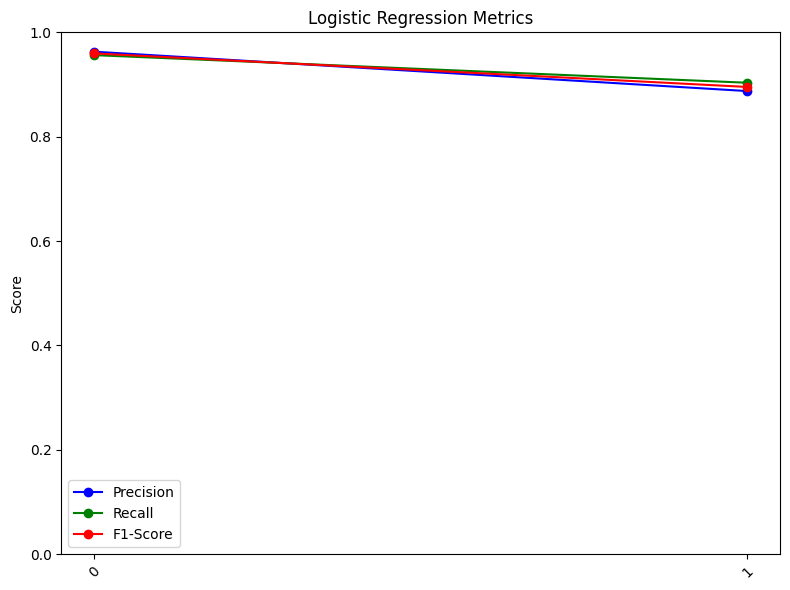

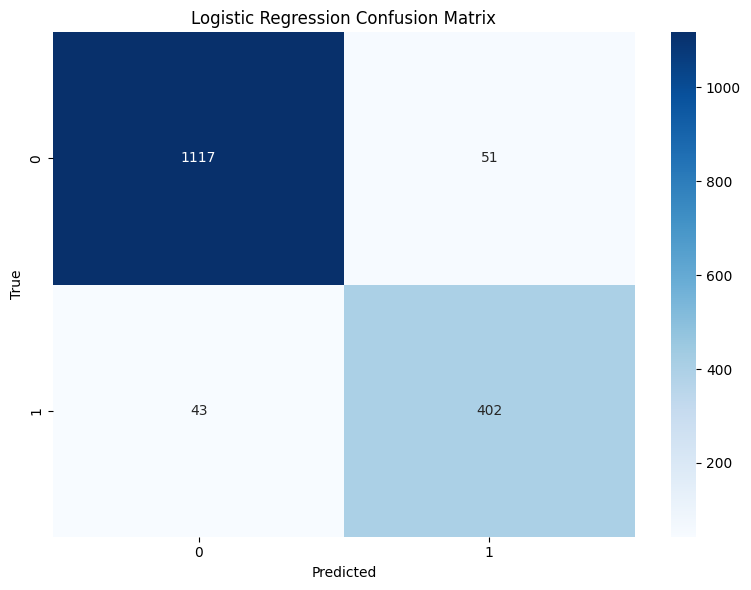

In [15]:

plt.figure(figsize=(8, 6))
plt.plot(categories, [report_lr[cat]['precision'] for cat in categories], marker='o', label='Precision', color='blue')
plt.plot(categories, [report_lr[cat]['recall'] for cat in categories], marker='o', label='Recall', color='green')
plt.plot(categories, [report_lr[cat]['f1-score'] for cat in categories], marker='o', label='F1-Score', color='red')
plt.ylim(0, 1)
plt.title('Logistic Regression Metrics')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_lr, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Dự đoán

In [16]:
def predict_label(text):
    # Tiền xử lý văn bản
    processed_text = preprocess_text(text)  # Chỉ nhận một giá trị trả về
    
    # Chuyển đổi văn bản thành đặc trưng với TF-IDF
    text_tfidf = tfidf_vectorizer.transform([processed_text])
    
    # Dự đoán nhãn với mô hình
    prediction = lr_model.predict(text_tfidf)
    
    # Chuyển đổi nhãn dự đoán thành tên nhãn nếu cần
    predicted_label = le.inverse_transform(prediction)
    
    return predicted_label[0]

# Nhập văn bản từ bàn phím
user_input = "Mình đang gặp khó khăn với việc sử dụng thư viện numpy. Mình không biết cách tạo một ma trận"

# Dự đoán nhãn của văn bản
predicted_label = predict_label(user_input)

print(f"Văn bản nhập vào thuộc về nhãn: {predicted_label}")

Văn bản nhập vào thuộc về nhãn: 0
